# Molecular Dynamics Simulation

N-body particle simulation with interatomic potentials and forces. Demonstrates classical mechanics, energy conservation, and thermodynamic properties of particle systems.

## Parimah Safarian 96109628

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial.distance import pdist , squareform
from numpy import *

Functions:

In [160]:
def v_cm(dots):
    vx = np.mean(dots[:, 2])
    vy = np.mean(dots[:, 3])
    return vx, vy

def cm_v_0(dots):
    vx, vy = v_cm(dots)
    dots[:, 2] -= vx
    dots[:, 3] -= vy


def temprature(dots,N):
    return np.sum(dots[:,2] * dots[:,2] + dots[:,3] * dots[:,3])/(2*N-2)


def kinetic(dots,N):
    return 0.5 * np.sum(dots[:,2] * dots[:,2] + dots[:,3] * dots[:,3])


def potential(dots,N):
    D = np.triu(squareform(pdist(dots[:,0:2]))) #Return a copy of a matrix with the elements below the k-th diagonal zeroed.
    D = D[D != 0] #excepting itself
    Dm6 = D ** -6
    U = 4 * np.sum(Dm6 ** 2 - Dm6)
    return U

def energy(dots,N):
    return kinetic(dots,N) + potential(dots,N)

def leftists(dots, N):
    lefts = dots[dots[:, 0] < L/2]
    return np.shape(lefts)[0]/N

import statsmodels.api as sm
def autocorrelation(x):
    """calculate autocorrelations"""
    return sm.tsa.acf(x)

In [77]:
acc = lambda r: 48 * ((r**-13) - 0.5*(r**-7))
def acceleration(dots, N, r_c):
    #copying the boundary particles
    extension1 = dots[dots[:, 0] < r_c]
    extension1[:, 0] += L

    extension2 = dots[dots[:, 0] > (L - r_c)]
    extension2[:, 0] -= L
    
    extension3 = dots[dots[:, 1] < r_c]
    extension3[:, 1] += L
    
    extension4 = dots[dots[:, 1] > (L - r_c)]
    extension4[:, 1] -= L
    
    extension5 = dots[((dots[:, 0] < r_c) & (dots[:, 1] < r_c))]
    extension5[:, 0] += L
    extension5[:, 1] += L
    
    extension6 = dots[((dots[:, 0] > (L-r_c)) & (dots[:, 1] < r_c))]
    extension6[:, 0] -= L
    extension6[:, 1] += L
    
    extension7 = dots[((dots[:, 0] < r_c) & (dots[:, 1] > (L-r_c)))]
    extension7[:, 0] += L
    extension7[:, 1] -= L
    
    extension8 = dots[((dots[:, 0] > (L-r_c)) & (dots[:, 1] > (L-r_c)))]
    extension8[:, 0] -= L
    extension8[:, 1] -= L
    
    new_dots = np.concatenate((dots, extension1, extension2, extension3, extension4,
                               extension5, extension6, extension7, extension8), axis=0) 
    #acceleration calculation
    D = squareform(pdist(new_dots[:,0:2]))
    D[D > r_c] = 0

    a = acc(D)
    where_nan = isnan(a)
    a[where_nan] = 0
    cos, sin = trigonometric(new_dots, np.shape(new_dots)[0], D)
    ax = a * cos
    where_nan = isnan(ax)
    ax[where_nan] = 0
    ax = ax.sum(axis = 1)[0:N]
    ay = a * sin
    where_nan = isnan(ay)
    ay[where_nan] = 0
    ay = ay.sum(axis = 1)[0:N]
    return ax, ay    

In [4]:
def trigonometric(dots, N, D):
    
    cos = np.zeros((N, N))
    sin = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            cos[i, j] = (dots[i, 0] - dots[j, 0]) / D[i, j]
            cos[j, i] = -cos[i, j]
            sin[i, j] = (dots[i, 1] - dots[j, 1]) / D[i, j]
            sin[j, i] = -sin[i, j]
    return cos, sin

In [17]:
def update(dots, ax, ay, L):
#     verlet
    dots[:, 0] += dots[:, 2] * h + 0.5 * ax * h ** 2
    dots[:, 1] += dots[:, 3] * h + 0.5 * ay * h ** 2
#     periodic boundary condition
    outs_x = np.where(abs(dots[:, 0] - L/2) > L/2)
    outs_y = np.where(abs(dots[:, 1] - L/2) > L/2)
    for i in outs_x:
        dots[i, 0] %= L
    for j in outs_y:
        dots[j, 1] %= L
        
    dots[:, 2] += 0.5 * ax * h                          
    dots[:, 3] += 0.5 * ay * h                          
    ax, ay = acceleration(dots, N, r_cutoff)
    
    dots[:, 2] += 0.5 * ax * h
    dots[:, 3] += 0.5 * ay * h
    return dots, ax, ay

In [126]:
#this function has been used for pressure calculation

def sum_force_distance(dots, N, r_c):
    #copying the boundary particles
    extension1 = dots[dots[:, 0] < r_c]
    extension1[:, 0] += L

    extension2 = dots[dots[:, 0] > (L - r_c)]
    extension2[:, 0] -= L
    
    extension3 = dots[dots[:, 1] < r_c]
    extension3[:, 1] += L
    
    extension4 = dots[dots[:, 1] > (L - r_c)]
    extension4[:, 1] -= L
    
    extension5 = dots[((dots[:, 0] < r_c) & (dots[:, 1] < r_c))]
    extension5[:, 0] += L
    extension5[:, 1] += L
    
    extension6 = dots[((dots[:, 0] > (L-r_c)) & (dots[:, 1] < r_c))]
    extension6[:, 0] -= L
    extension6[:, 1] += L
    
    extension7 = dots[((dots[:, 0] < r_c) & (dots[:, 1] > (L-r_c)))]
    extension7[:, 0] += L
    extension7[:, 1] -= L
    
    extension8 = dots[((dots[:, 0] > (L-r_c)) & (dots[:, 1] > (L-r_c)))]
    extension8[:, 0] -= L
    extension8[:, 1] -= L
    
    new_dots = np.concatenate((dots, extension1, extension2, extension3, extension4,
                               extension5, extension6, extension7, extension8), axis=0) 
    #acceleration calculation
    D =  np.triu(squareform(pdist(new_dots[:,0:2])))
    D[D > r_c] = 0

    a = acc(D)
    where_nan = isnan(a)
    a[where_nan] = 0
    ad = a * D
#     print(np.shape(ad.sum(axis = 1)))

    return np.sum(ad.sum(axis = 1)[0:N])

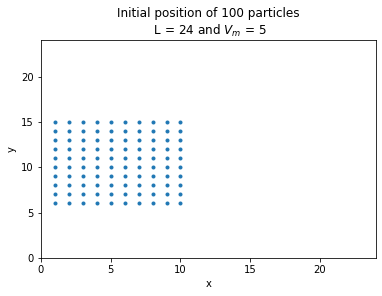

In [283]:
#initial conditions

L = 24
sqrt_n = 10
N = sqrt_n ** 2

vmax = 5
dots = np.random.rand(N,4)

dots[:,0:2] = 0


for i in range(sqrt_n):
    for j in range(sqrt_n):
        dots[sqrt_n*i+j,0] = 1.0*i + 1
        dots[sqrt_n*i+j,1] = 1.0*j + L/4


dots[:,2:] *= vmax

cm_v_0(dots)

plt.plot(dots[:, 0], dots[:, 1], '.')
plt.ylim(0, L)
plt.xlim(0, L)
plt.ylabel("y")
plt.xlabel("x")
plt.title("Initial position of {} particles\n L = {} and $V_m$ = {}".format(N, L, vmax))

plt.savefig("init_pos.png")

C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_

Wall time: 1min 34s


Text(0.5, 1.0, 'Final position of 100 particles in time 3.0')

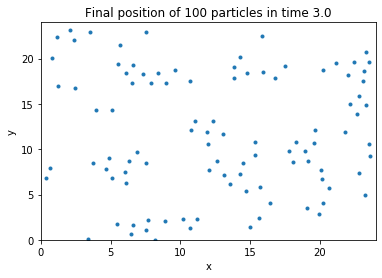

In [284]:
%%time
time = 600
r_cutoff = 2.5
h = 5e-3
# k_b = 1.38e-23

E = []
U = []
K = []
T = []
P = []
V = []
lefts = []

ax, ay = acceleration(dots, N, r_cutoff)

for t in range(time):
    dots, ax, ay = update(dots, ax, ay, L)
    K.append(kinetic(dots, N))
    U.append(potential(dots, N))
    E.append(K[t] + U[t])
    T.append(temprature(dots,N))
    P.append(L ** -2 * (N * T[t] - 0.5 * sum_force_distance(dots, N, r_cutoff)))
    if t%5 == 0:
        V.append((dots[:, 2] ** 2 + dots[:, 3] ** 2) ** 0.5)
    lefts.append(leftists(dots, N))

plt.plot(dots[:, 0], dots[:, 1], '.')
plt.ylim(0, L)
plt.xlim(0, L)
plt.ylabel("y")
plt.xlabel("x")
plt.title("Final position of {} particles in time {}".format(N, time * h))

# plt.savefig("final_pos.png")

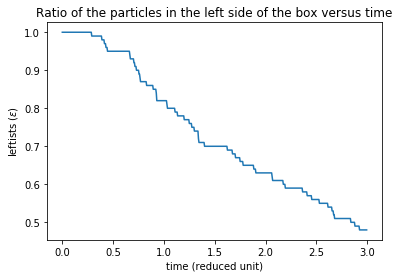

In [266]:
plt.plot(np.arange(time) * h, lefts)

plt.title("Ratio of the particles in the left side of the box versus time")
plt.ylabel("leftists ($\epsilon$)")
plt.xlabel("time (reduced unit)")
plt.savefig("left.png")

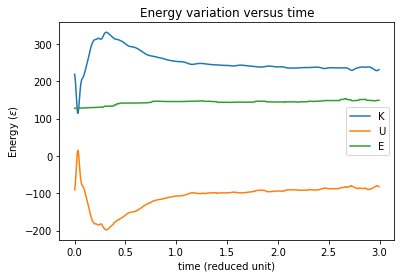

In [267]:
plt.plot(np.arange(time) * h, K, label = 'K')
plt.plot(np.arange(time) * h, U, label = 'U')
plt.plot(np.arange(time) * h, E, label = 'E')
plt.legend()
plt.title("Energy variation versus time")
plt.ylabel("Energy ($\epsilon$)")
plt.xlabel("time (reduced unit)")
plt.savefig("energy.png")

2.374021634430192 0.028500955778523653


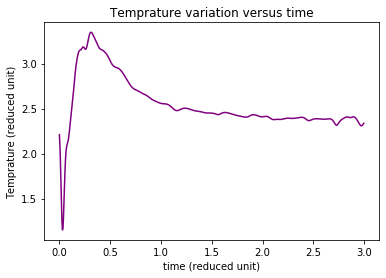

In [268]:
plt.plot(np.arange(time) * h, T, c = 'purple')
# plt.legend()
plt.title("Temprature variation versus time")
plt.ylabel("Temprature (reduced unit)")
plt.xlabel("time (reduced unit)")
plt.savefig("temp.png")
print(np.mean(T[500:600]), np.std(T[500:600]))

0.4729614052439201 0.07860149294528565


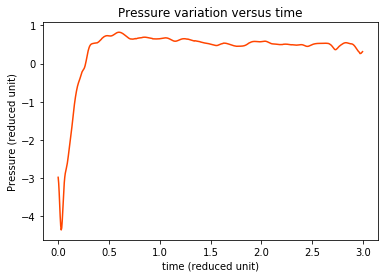

In [269]:
plt.plot(np.arange(time) * h, P, c = 'orangered')
# plt.legend()
plt.title("Pressure variation versus time")
plt.ylabel("Pressure (reduced unit)")
plt.xlabel("time (reduced unit)")
plt.savefig("press.png")
print(np.mean(P[500:600]), np.std(P[500:600]))

## Autocorrelation and relaxation time

C:\Users\Asus\Anaconda3_0\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


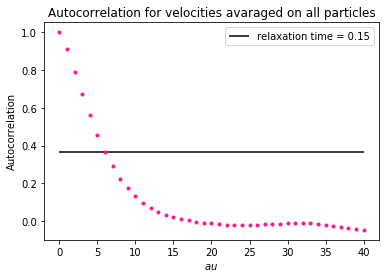

In [313]:
vel = np.zeros(np.shape(V))
ts  = np.shape(V)[0]
for t in range(ts):
    vel[t, :] = V[t]
    
acorrelation_av = 0
for i in range(N):
    acorrelation_av += np.array(autocorrelation(vel[:, i]))
    
acorrelation_av /= N

plt.plot(acorrelation_av, '.', c = 'deeppink')
plt.title("Autocorrelation for velocities avaraged on all particles")
plt.ylabel("Autocorrelation")
plt.xlabel("$\tau$")
plt.hlines(y = 1/np.e, xmin = 0, xmax = 40, label = f'relaxation time = {6 * 5 * h}')
plt.legend()
plt.savefig("ac.png")

## Vaderwaals and phase transition

In [271]:
v_range = np.concatenate((np.arange(0.05, 1, 0.05), np.arange(1, 2.5, 0.15)), axis=0)
np.size(v_range)

29

In [276]:
%%time

L = 24
sqrt_n = 10
N = sqrt_n ** 2
time = 600
r_cutoff = 2.5
h = 5e-3
# k_b = 1.38e-23
P_eq = []
T_eq = []
E_eq = []


for vmax in v_range:
    dots = np.random.rand(N,4)

    dots[:,0:2] = 0


    for i in range(sqrt_n):
        for j in range(sqrt_n):
            dots[sqrt_n*i+j,0] = 1.0*i + L/4
            dots[sqrt_n*i+j,1] = 1.0*j + L/4

    dots[:,2:] *= vmax


    T = []
    P = []
    E = []

    ax, ay = acceleration(dots, N, r_cutoff)
    mean_on = 100
    for t in range(time):
        dots, ax, ay = update(dots, ax, ay, L)
        T.append(temprature(dots,N))
        P.append(L ** -2 * (N * T[t] - 0.5 * sum_force_distance(dots, N, r_cutoff)))
        if t > (time - mean_on):
            E.append(energy(dots, N))
    T_eq.append(np.mean(T[time-mean_on:time]))
    P_eq.append(np.mean(P[time-mean_on:time]))
    E_eq.append(np.mean(E[:]))
    
    


C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_

Wall time: 27min 5s


Text(0, 0.5, 'P')

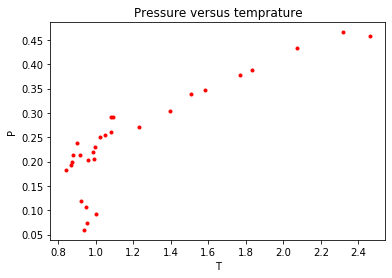

In [277]:
plt.title("Pressure versus temprature")
plt.plot(T_eq, P_eq, '.', c = 'r')
plt.xlabel("T")
plt.ylabel("P")

# plt.savefig("vander.png")

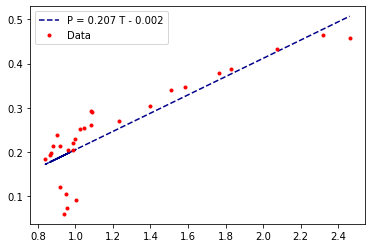

In [281]:
a, b = np.polyfit(T_eq, P_eq, 1)
plt.plot(T_eq, a * np.array(T_eq) + b , '--', c = 'darkblue', label = f'P = {np.round(a, 3)} T - {-np.round(b, 3)}')
plt.plot(T_eq, P_eq, '.', c = 'r', label = 'Data')
plt.legend()

# plt.savefig("vander.png")

In [261]:
# v_range = 0.1 ** np.arange(4, 10)

v_range = np.concatenate((np.arange(0.0005, 0.1, 0.0055), np.arange(0.1, 2.5, 0.1)), axis=0)
# np.size(v_range)
v_range

array([1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09])

In [262]:
%%time

L = 30
sqrt_n = 10
N = sqrt_n ** 2
time = 500
r_cutoff = 2.5
h = 5e-3
# k_b = 1.38e-23
# P_eq = []
# T_eq = []
# E_eq = []


for vmax in v_range:
    dots = np.random.rand(N,4)

    dots[:,0:2] = 0


    for i in range(sqrt_n):
        for j in range(sqrt_n):
            dots[sqrt_n*i+j,0] = 1.0*i + int(L/4)
            dots[sqrt_n*i+j,1] = 1.0*j + int(L/4)

    dots[:,2:] *= vmax
    cm_v_0(dots)

    T = []
#     P = []
    E = []

    ax, ay = acceleration(dots, N, r_cutoff)
    mean_on = 50
    for t in range(time):
        dots, ax, ay = update(dots, ax, ay, L)
        T.append(temprature(dots,N))
#         P.append(L ** -2 * (N * T[t] - 0.5 * sum_force_distance(dots, N, r_cutoff)))
        if t > (time - mean_on):
            E.append(energy(dots, N))
    T_eq.append(np.mean(T[time-mean_on:time]))
#     P_eq.append(np.mean(P[time-mean_on:time]))
    E_eq.append(np.mean(E[:]))

C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3_0\lib\site-packages\ipykernel_

Wall time: 1min 21s


Text(0, 0.5, 'E')

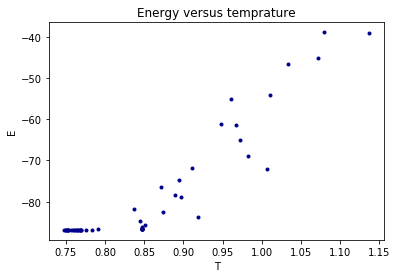

In [263]:
plt.title("Energy versus temprature")
plt.plot(T_eq, E_eq, '.', c = 'darkblue')
plt.xlabel("T")
plt.ylabel("E")
# plt.savefig("phase.png")